In [20]:
import jax
import optax
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel.experimental.optim as opt
import liesel.goose as gs
import liesel.model as lsl

We take a super simple Liesel model here

In [21]:
xval = 2.0 * jax.random.normal(jax.random.key(42), (100_000,)) + 3.0

Next, we create a train/validation/test split of the data.

In [22]:
split = opt.Split.from_share(
    position_keys=["x"],
    n=xval.size,  # full size of the axis along which we split
    share_validate=0.0,
    share_test=0.0,  # I don't use any test data in this example
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
    # -
    # indices can be shuffled
    shuffle=True,
    seed=1,
)

# Finally, we apply the split to the position
position = {"x": xval}
data = split.split_position(position)

Next, we prepare batching.

In [23]:
bi = opt.Batches(
    position_keys=["x"],
    n=data.n_train,  # full size of the training data set.
    batch_size=1024,
    shuffle=True,  # can be set to turn off shuffling in Batches.permute_indices
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
)
initial_batch = bi.get_batched_position(data.train, batch_index=0)

In [24]:
m = lsl.Var.new_param(0.0, name="m")
s = lsl.Var.new_param(1.0, name="s")
s.transform(tfb.Exp())
x = lsl.Var.new_obs(
    initial_batch["x"],
    distribution=lsl.Dist(tfd.Normal, loc=m, scale=s),
    name="x",
)
p = lsl.Model([x])

Now we build the  variational distribution.
Here, we used two independent Gaussian distributions for the parameters.

In [25]:
q1 = opt.VDist(["m"], p).mvn_diag()
q2 = opt.VDist(["s_transformed"], p).mvn_diag()
vi_dist = opt.CompositeVDist(q1, q2).build()
parameters = vi_dist.parameters

Next, we initialize our loss object.

In [26]:
loss = opt.Elbo.from_vdist(vi_dist, data, nsamples=10, nsamples_validate=100)

Next, we initialize the optimizer.

In [27]:
optim = opt.Optimizer(parameters, optimizer=optax.adam(learning_rate=1e-3))

Next, we initialize the engine.

In [28]:
engine = opt.OptimEngine(
    loss=loss,
    batches=bi,
    split=data,
    optimizers=[optim],
    stopper=opt.Stopper(epochs=1000, patience=50, atol=0.0, rtol=1e-3),
    seed=42,
    initial_state=p.state,
    restore_best_position=True,
    prune_history=True,
    show_progress=True,
    save_position_history=True,
    progress_n_updates=100,
)

Finally, we run the optimization.

In [29]:
result = engine.fit()

Training loss: 211060.031, Validation loss: 211060.031:  11%|█▏        | 114/1000 [00:05<00:41, 21.12it/s]


Now we can inspect the loss and parameter history.

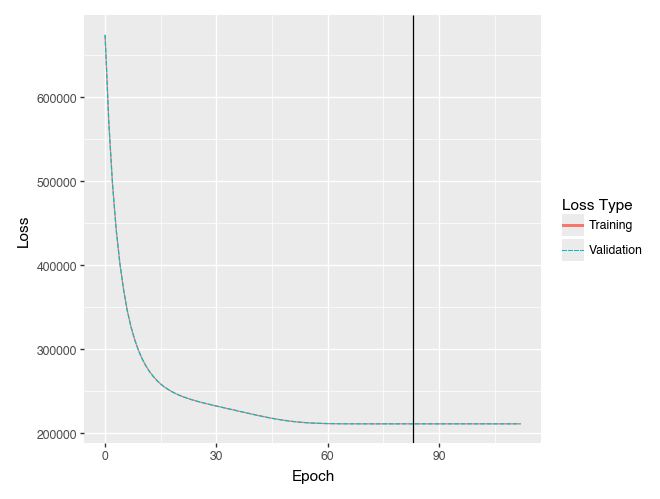

In [30]:
result.plot_loss()

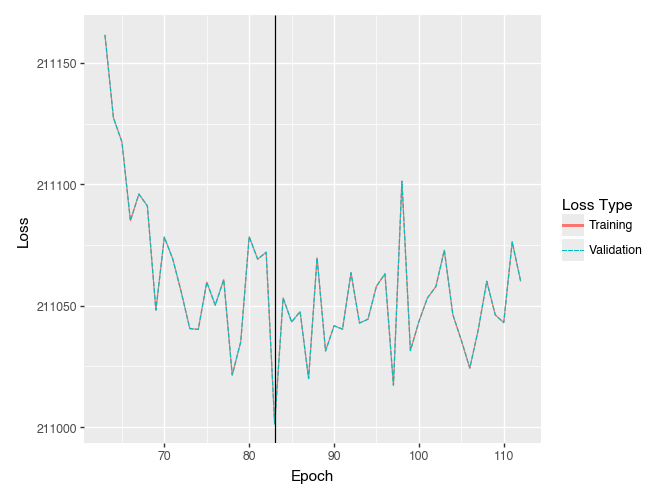

In [31]:
result.plot_loss(window=50)

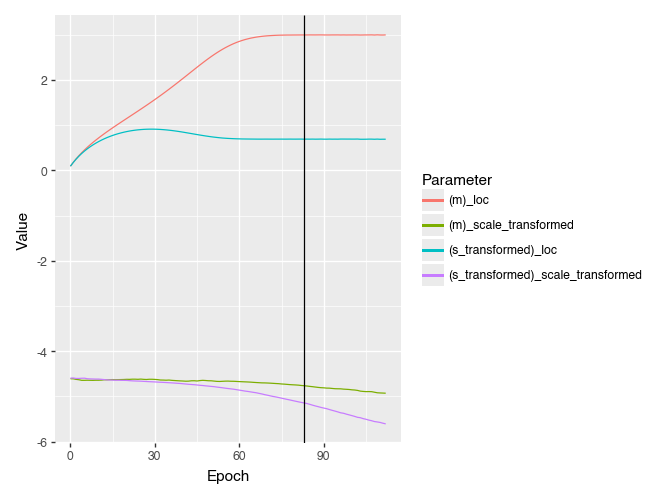

In [32]:
result.plot_params()

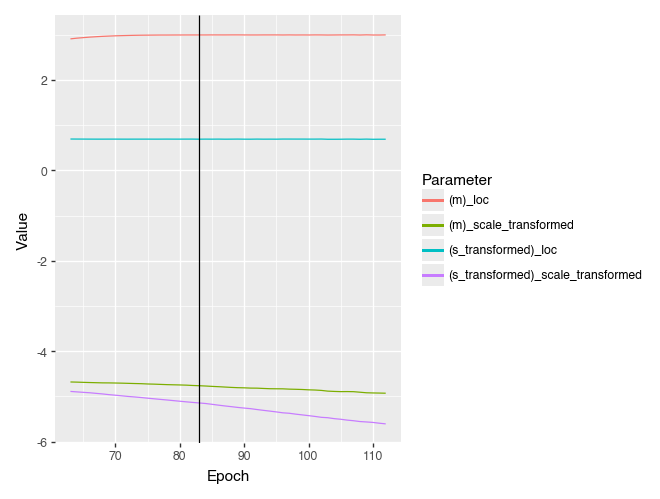

In [33]:
result.plot_params(window=50)

For VI, we can now sample from the variational distribution and translate these samples
 into a form that is easily usable as an approximation to the posterior.
We can then use the existing goose functionality to summarize the samples, etc.

In [34]:
p_samples = vi_dist.sample_p(
    n=1000, seed=jax.random.key(42), prepend_axis=True, at_position=result.best_position
)

# add samples of the actual quantity of interest
s_samples = p.predict(p_samples, predict=["s"])
summary = gs.SamplesSummary(p_samples | s_samples)
summary.to_dataframe()

,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
variable,,,,,,,,,,,,,,,
m,m,(),1000,2.995674,0.000072,0.008482,1024.143640,888.472219,0.000266,0.000193,2.982071,2.995355,3.009702,2.983526,3.010792
s,s,(),1000,1.994694,0.000132,0.011478,912.287743,933.537162,0.000381,0.000260,1.976036,1.994537,2.014227,1.976040,2.014243
s_transformed,s_transformed,(),1000,0.690474,0.000033,0.005753,912.287743,933.537162,0.000191,0.000130,0.681093,0.690412,0.700236,0.681095,0.700244


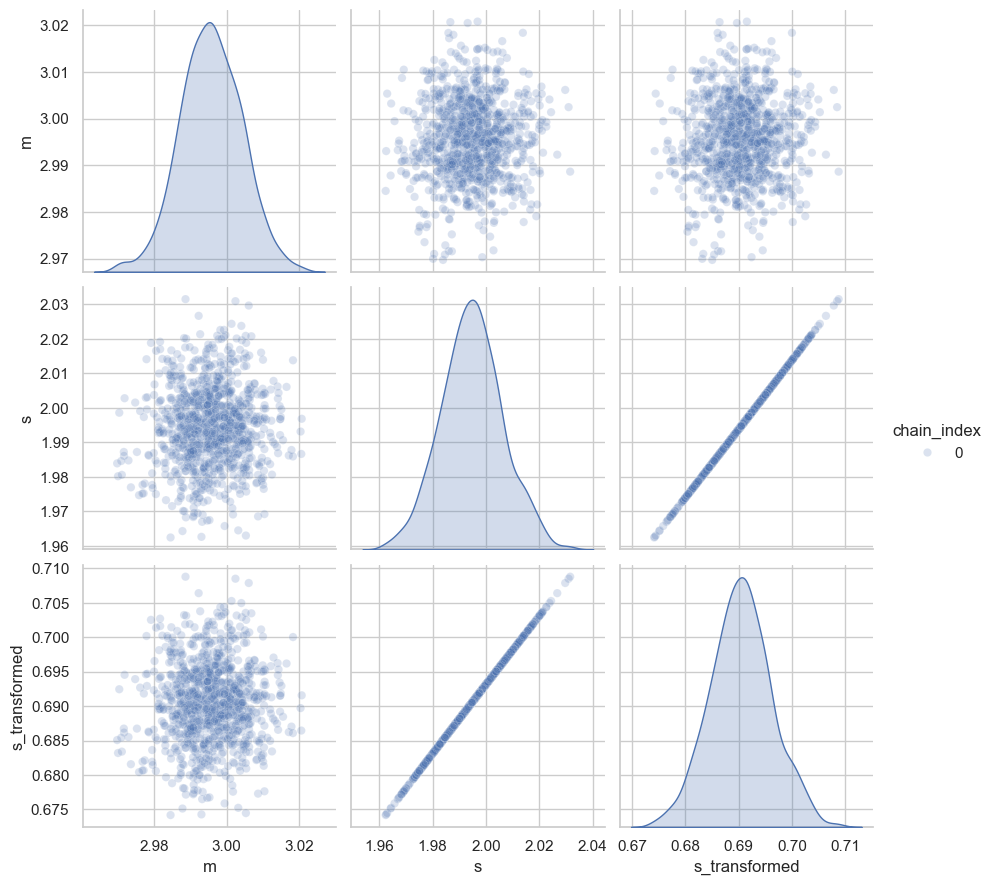

In [35]:
gs.plot_pairs(p_samples | s_samples)

## Variations

### One combined variational dist

In [36]:
vi_dist = opt.VDist(["m", "s_transformed"], p).mvn_diag()

### Custom variational dist

In [37]:
q1 = opt.VDist(["m"], p).mvn_diag()

dist_s_transformed = lsl.Dist(
    tfd.LogNormal,
    loc=lsl.Var.new_param(0.0, name="(s_transformed)_loc"),
    scale=lsl.Var.new_param(1.0, name="(s_transformed)_scale"),
)
dist_s_transformed["scale"].transform(tfb.Softplus())

# VDist.init takes any liesel distribution
q2 = opt.VDist(["s_transformed"], p).init(dist=dist_s_transformed)

vi_dist = opt.CompositeVDist(q1, q2).build()
parameters = vi_dist.parameters

### Blocked optimizers

In [38]:
opt1 = opt.Optimizer(q1.parameters, optimizer=optax.adam(learning_rate=1e-2))
opt2 = opt.Optimizer(q2.parameters, optimizer=optax.adam(learning_rate=1e-5))
optimizers = [opt1, opt2]